# Práctica FISH — Implementación *estilo Vera* (técnicas tradicionales) + soporte de labels

Este notebook implementa la opción **1) Solo tradicionales (como el TFG de Vera)** 

## Qué hace
1. **Carga** las imágenes FISH (`imgs/tiff/*.tiff`).
2. **Segmenta células** con técnicas tradicionales:
   - Opción A (por defecto): si existen **labels** (`imgs/labels/*.label.tiff`), los usa como segmentación de célula (muy útil para depurar y validar).
   - Opción B: si no hay labels (o lo desactivas), hace una **segmentación automática** (gris + Otsu/adaptativo + morfología) y separa células pegadas con **Watershed**.
3. **Detecta sondas** (rojas y verdes/azules) con **HSV + blobs**.
4. **Asigna sondas a cada célula**, cuenta y **clasifica** cada célula:
   - **a_normal**: 2 control (verde/azul) y ≥2 interés (rojo)  
   - **b_del_1_brazo**: 2 control y 1 rojo  
   - **c_del_2_brazos**: 2 control y 0 rojos  
   Si una célula tiene <2 sondas de control: `descartar`.

### Técnicas Utilizadas

Este notebook usa técnicas **clásicas probadas** sin deep learning:
- Conversión de espacios de color (RGB → Gris → HSV)
- Procesamiento morfológico (erosión, dilatación, cierre)
- Binarización automática (Otsu)
- Separación de objetos pegados (Watershed + Distance Transform)
- Detección de color (HSV thresholding)
- Análisis espacial (connected components)

### Ventajas del Enfoque

| Característica | Beneficio |
|---|---|
| **Interpretable** | Cada paso es transparente, no es "caja negra" |
| **Determinístico** | Mismo input → Mismo output siempre |
| **Rápido** | ~1-2 segundos por imagen |
| **Sin entrenamiento** | No necesita datos etiquetados |
| **Ajustable** | Parámetros modificables según datos |

## Salidas
- `resultados_por_celula.csv` → una fila por célula
- `resumen_global.csv` → conteo y porcentaje por clase
- Figuras de debug en las primeras imágenes
---

## Instalaciones Necesarias para Ejecutar el Notebook FISH
### 1. Crear Entorno Conda (Recomendado)
```
conda create -n fish_analysis python=3.9 -y
conda activate fish_analysis
```

### 2. Instalación de Librerías Principales
```
pip install numpy pandas matplotlib seaborn jupyter ipywidgets opencv-python scikit-image scikit-learn scipy tifffile tqdm
````

---

## 0) Imports

---

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage import measure, morphology, segmentation, filters
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

import tifffile as tiff


---
## 1) Rutas y parámetros

### Rutas

- **BASEDIR:** Directorio con carpeta `imgs/` (imágenes TIFF)
- **IMGDIR:** `imgs/` con archivos como `cell00001.tiff`
- **LABELDIR:** `imgs/labels/` con máscaras opcionales `cell00001.label.tiff`

Pon `BASE_DIR` apuntando a la carpeta `trabajo25_26` (la que contiene `imgs/`).

### Parámetros de Control

- **DEBUGFIRSTN:** Cuántas imágenes mostrar con debug (figuras). Aumentar si se quiere ver más ejemplos. 
- **USE_LABELS_IF_AVAILABLE:** Usar máscaras manuales si existen (True/False)

### Parámetros de Segmentación
Los siguientes parámetros controlan cómo se detectan y segmentan las células:
- **minarea:** Tamaño mínimo de célula en píxeles (por defecto 1500). Células más pequeñas serán rechazadas como ruido.
- **holesize:** Tamaño máximo de agujeros a rellenar dentro de células (por defecto 1500). Es decir:
  - Agujeros < 1500px se rellenan (ruido interno)
  - Agujeros > 1500px se respetan (posibles características reales)
- **mindistance:** Distancia mínima entre centros de células para Watershed (por defecto 20).

### Parámetros de Detección de Sondas (HSV)
- **green_h, red_h:** Rangos de Hue para detección de colores
  
- **sat_min, val_min:** Umbrales mínimos de Saturación y Valor
  - S > 70: Filtra grises (colores desaturados)
  - V > 70: Filtra negros (píxeles oscuros)
  - **Aumentar estos valores:** Más selectivo, menos falsos positivos
  - **Disminuir:** Detecta más sondas débiles

- **min_blob_area, max_blob_area:** Rango de tamaño de sonda en píxeles
  

---



In [16]:
BASE_DIR = r"D:\Master\Imagenes\Practicas\trabajo"  

IMG_DIR = os.path.join(BASE_DIR, "imgs", "tiff")
LABEL_DIR = os.path.join(BASE_DIR, "imgs", "labels")

# Salidas
OUT_PER_CELL = "resultados_por_celula.csv"
OUT_SUMMARY = "resumen_global.csv"

# Debug
DEBUG_FIRST_N = 5

# Si hay labels, usar por defecto (más robusto).
USE_LABELS_IF_AVAILABLE = True


---

## 2) Utilidades

## Funciones Auxiliares
Estas funciones simples son utilizadas a lo largo del pipeline para visualización y procesamiento básico.

### show()
Muestra una imagen de forma legible en el notebook con título opcional.
- Convierte BGR (formato OpenCV) a RGB (formato estándar de visualización)
- Ajusta el tamaño de la figura para mejor visualización

### overlay_mask()
Superpone una máscara coloreada sobre una imagen original, permitiendo visualizar qué píxeles han sido detectados.
- **Uso:** Visualizar células detectadas, sondas, etc.
- **Parámetros:** color (BGR), alpha (transparencia 0-1)
- **Resultado:** Imagen con overlay semi-transparente

### find_images()
Busca automáticamente todas las imágenes en un directorio.
- Soporta múltiples formatos: .tif, .tiff, .png, .jpg, .jpeg
- Devuelve lista ordenada alfabéticamente
- Útil para procesar lotes de imágenes

---

In [3]:
def show(img_bgr, title=None, size=7):
    plt.figure(figsize=(size, size))
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    if title: plt.title(title)
    plt.axis("off")
    plt.show()

def overlay_mask(img_bgr, mask_bool, color=(0,255,255), alpha=0.35):
    out = img_bgr.copy()
    colored = np.zeros_like(out)
    colored[mask_bool] = color
    return cv2.addWeighted(out, 1.0, colored, alpha, 0)

def find_images(img_dir):
    exts = (".tif", ".tiff", ".png", ".jpg", ".jpeg")
    paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.lower().endswith(exts)])
    if not paths:
        raise FileNotFoundError(f"No encuentro imágenes en: {img_dir}")
    return paths


---

## 3) Segmentación tradicional de células (solo si no usamos labels)

- grayscale + blur
- Otsu (o adaptativo)
- morfología (rellenar huecos / quitar pequeños)

## Paso 1: Segmentación de Células (Opción Automática)
La segmentación es el proceso de separar las células del fondo en la imagen.

### ¿Por qué es importante?
Una buena segmentación es fundamental para:
- Identificar correctamente dónde está cada célula
- Evitar confundir fondo con células (falsos positivos)
- Preparar la imagen para pasos posteriores

### Proceso Paso a Paso
#### 1. **Conversión a Escala de Grises**
```
Imagen RGB (3 canales) → Imagen Gris (1 canal)
```
#### 2. **Suavizado Gaussiano**
Aplica un filtro Gaussiano para reducir ruido.
- **σ = 1.0:** Balance entre suavizado y preservación de detalles
- **Efecto:** Reduce ruido y previene sobre-segmentación

#### 3. **Binarización Otsu**
Convierte la imagen gris en binaria. **Elige el umbral óptimo que minimiza la varianza intra-clase**

#### 4. **Operaciones Morfológicas**
Después de binarización, la máscara tiene problemas:

**a) Relleno de Huecos Pequeños:**
- Detecta agujeros pequeños dentro de células (ruido interno)
- Si agujero < 1500 píxeles → rellena
- Si agujero > 1500 píxeles → deja vacío

**b) Eliminación de Objetos Pequeños:**
- Detecta regiones blancas pequeñas (ruido externo)
- Si región < 1500 píxeles → elimina
- Si región > 1500 píxeles → mantiene

**c) Cierre Morfológico (Closing):**
- **Erosión:** Reduce objetos (elimina borde de 1px)
- **Dilatación:** Expande objetos (añade borde de 1px)
- **Neto:** Llena pequeños agujeros + suaviza bordes

### Resultado

Una máscara binaria limpia donde:
- Píxeles blancos (1) = células detectadas
- Píxeles negros (0) = fondo

---

In [4]:
def segment_cells_binary(img_bgr, use_adaptive=False, min_area=1500, hole_size=1500):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (0,0), 1.0)   # Suavizado ligero antes de umbralizar, hemos escogido un sigma de 1 ya que permite eliminar ruido sin perder detalles importantes.

    if use_adaptive:
        thr = cv2.adaptiveThreshold(
            gray, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            51, 2
        )   
        mask = (thr > 0)
    else:
        t = filters.threshold_otsu(gray)
        # Si te sale al revés, cambia a: mask = gray > t
        mask = gray < t

    mask = morphology.remove_small_holes(mask, area_threshold=hole_size)
    mask = morphology.remove_small_objects(mask, min_size=min_area)
    mask = morphology.binary_closing(mask, morphology.disk(3))
    return mask.astype(np.uint8)


---
## 4) Watershed

## Paso 2: Separación de Células Pegadas - Watershed

### El Problema: Células Tocándose
En imágenes reales, las células a menudo se tocan entre sí, formando una región conectada única. Si usamos segmentación simple, se detectarían como **una sola célula gigante** en lugar de dos células separadas.

**Solución:** Algoritmo Watershed

### ¿Cómo funciona Watershed?
Imagina un terreno montañoso:
1. **Cálculo de Distancia:**
   - Para cada píxel dentro de la célula, calcula: "¿Cuán lejos estoy del borde?"
   - Resultado: Mapa de altitud donde centro > borde

2. **Detección de Picos:**
   - Encuentra máximos locales en el mapa de distancia
   - Cada pico = probablemente el centro de una célula
   - Si hay 2 picos → hay 2 células pegadas

3. **Simulación de Agua:**
   - Coloca una "semilla" (marcador) en cada pico
   - Simula agua fluyendo cuesta abajo (hacia borde)
   - El agua de diferentes semillas NO se mezcla
   - Resultado: Límites automáticos entre células

### Ventajas de Watershed

- Automático (no necesita parámetro "número de células")
- Basado en geometría (respeta formas naturales)
- Muy utilizado en segmentación biológica
- Rápido y eficiente

### Parámetros Importantes

- **mindistance = 20:** Dos picos deben estar ≥ 20 píxeles separados
  - Si están más cerca, se considera la misma célula

### Resultado

Un mapa de etiquetas donde:
- Píxel valor 0 = fondo o línea Watershed
- Píxel valor 1,2,3... = ID de célula

In [5]:
def split_cells_watershed(bin_mask, min_distance=20):
    mask_bool = bin_mask.astype(bool)
    dist = ndi.distance_transform_edt(mask_bool)

    coords = peak_local_max(dist, labels=mask_bool, min_distance=min_distance)
    markers = np.zeros_like(bin_mask, dtype=np.int32)
    for i, (r, c) in enumerate(coords, start=1):
        markers[r, c] = i

    labels = segmentation.watershed(-dist, markers, mask=mask_bool)
    return labels.astype(np.int32)


## 5) Cargar labels (si existen)

Los archivos `.label.tiff` contienen **máscaras manuales pre-anotadas** en escala de grises donde:
- Píxel valor 0 = fondo
- Píxel valor 1-255 = ID de la célula (anotada manualmente)

**Uso:**
- Ground truth para validación
- Verificación de calidad del método automático
- Comparación de precisión

### Cuándo Usar Labels

- **Si disponibles y USE_LABELS_IF_AVAILABLE=True:**
  - Salta la segmentación automática
  - Usa directamente las máscaras manuales
  - Más robusto (sin errores de segmentación)
  - Ideal para validación

- **Si no disponibles o USE_LABELS_IF_AVAILABLE=False:**
  - Usa segmentación automática (Watershed)
  - Más rápido pero puede tener errores
  - Funciona bien en imágenes limpias

In [6]:
def load_label_if_exists(img_path, label_dir):
    base = os.path.basename(img_path)
    name, _ = os.path.splitext(base)
    # soportar .tiff y .tif
    if name.lower().endswith(".tif"):
        name = name[:-4]
    label_name = f"{name}.label.tiff"
    label_path = os.path.join(label_dir, label_name)
    if not os.path.exists(label_path):
        return None

    lab = tiff.imread(label_path)  # (H,W,3) uint8
    if lab.ndim == 3 and lab.shape[2] == 3:
        lab = lab[..., 0]
    lab = lab.astype(np.int32)
    return lab


## 6) Detección de sondas (HSV + blobs)

- Rojo: dos rangos en H (cerca de 0 y cerca de 179)
- Verde/azulado: rango amplio (ajustable)

## Paso 3: Detección de Sondas Fluorescentes
### Cambio de Espacio de Color: RGB → HSV
Las imágenes FISH contienen información de color importante:
- Información roja/verde en los canales RGB
- PERO: RGB no es el mejor espacio para detectar colores

**¿Por qué HSV es mejor?**

| Aspecto | RGB | HSV |
|--------|-----|-----|
| Rojo oscuro (150,0,0) | Diferente | H=0 (igual) |
| Rojo brillante (255,0,0) | Diferente | H=0 (igual) |
| Difícil threshold | ❌ Sí | ✅ No |
| Fácil filtrar por saturación | ❌ No | ✅ Sí |

### Componentes HSV

- **H (Hue/Matiz):** ¿Qué color? (0-180 en OpenCV, escala 0-360°)
  ```
        0° (Rojo)
      ↙      ↖
    300°      60°
  (Magenta)  (Verde)
  ```
  
- **S (Saturation/Saturación):** ¿Cuán puro es el color? (0-255)
  - 0 = gris (desaturado)
  - 255 = color puro
  
- **V (Value/Brillo):** ¿Cuán brillante? (0-255)
  - 0 = negro
  - 255 = blanco/brillante

### Detección de Sondas Rojas

```python
# Rangos de Hue para rojo (circular)
redh1 = [10, 12]      # Rojo puro en un extremo
redh2 = [165, 179]    # Rojo en el otro extremo

# Condiciones
red = ((H en redh1 O H en redh2) AND 
       S >= 70 AND                    # Color debe ser saturado
       V >= 70)                       # Debe ser suficientemente brillante
```

**¿Por qué dos rangos de Hue?**
Hue es circular: 0° ≡ 360°. Rojo ocupa ambos extremos.

**Filtros S y V:**
- S > 70: Elimina grises (que tienen bajo S)
- V > 70: Elimina negros (que tienen bajo V)
- Resultado: Solo rojos reales, menos ruido

### Detección de Sondas Verde/Azul (Control)

```python
greenh = [35, 110]    # Rango verde-azulado

green = (H en greenh AND 
         S >= 70 AND
         V >= 70)
```

### Limpieza Morfológica

Después de detectar píxeles de color, los resultados tienen ruido (píxeles aislados).

**Morphological Opening** (Erosión + Dilatación):
- **Erosión:** Elimina píxeles aislados (ruido = 1-2 píxeles)
- **Dilatación:** Restaura objetos principales
- **Resultado:** Ruido eliminado, sondas preservadas

### Extracción de Centroides

Para cada región detectada:
1. Etiqueta región conectada con ID único
2. Calcula propiedades (área, centroide)
3. Filtra por tamaño: 3 < área < 500 píxeles
4. Extrae coordenadas del centroide [x, y]

**Resultado:** Lista de puntos donde están las sondas

---

In [7]:
def detect_probes_hsv(img_bgr,
                      green_h=(35, 110),
                      red_h1=(0, 12),
                      red_h2=(165, 179),
                      sat_min=70,
                      val_min=70,
                      min_blob_area=3,
                      max_blob_area=500):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    H, S, V = hsv[..., 0], hsv[..., 1], hsv[..., 2]

    green = (H >= green_h[0]) & (H <= green_h[1]) & (S >= sat_min) & (V >= val_min)
    red = (((H >= red_h1[0]) & (H <= red_h1[1])) | ((H >= red_h2[0]) & (H <= red_h2[1])))           & (S >= sat_min) & (V >= val_min)

    kernel = np.ones((3, 3), np.uint8)
    green = cv2.morphologyEx(green.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=1)
    red   = cv2.morphologyEx(red.astype(np.uint8),   cv2.MORPH_OPEN, kernel, iterations=1)

    def blobs(mask_u8):
        lab = measure.label(mask_u8 > 0, connectivity=2)
        pts = []
        for r in measure.regionprops(lab):
            if r.area < min_blob_area or r.area > max_blob_area:
                continue
            cy, cx = r.centroid
            pts.append((float(cx), float(cy)))
        return pts

    green_pts = blobs(green)
    red_pts = blobs(red)
    return green_pts, red_pts


---
## 7) Conteo por célula + clasificación

---
## Paso 4: Conteo de Sondas por Célula
### El Problema: ¿A cuál célula pertenece cada sonda?

Tenemos:
1. Mapa de células etiquetadas (labels)
2. Coordenadas de sondas rojas [x_r, y_r]
3. Coordenadas de sondas verdes [x_g, y_g]

**Pregunta:** ¿Cuántas sondas rojas hay en la célula #1? ¿Y verdes?

### Solución: Spatial Lookup (Búsqueda Espacial)
Para cada sonda detectada:
1. Toma sus coordenadas [x, y]
2. Consulta el mapa de labels: `cell_id = labels[y, x]`
3. Si cell_id > 0 (no fondo): incrementa contador para esa célula

### Ventajas de este Método

- **Exacto:** Si la sonda está dentro de la célula i, pertenece a i
- **Rápido:** Solo busca en el mapa (no calcula distancias)
- **Simple**

### Resultado
Para cada célula: diccionario con:
- `"green"`: número de sondas verdes detectadas
- `"red"`: número de sondas rojas detectadas
---

## Paso 5: Clasificación de Células
```
¿Cuántas sondas rojas y verdes hay?
    ↓
├─ Verde < 2?
│  └─ ❌ descartar
│     Razón: Control probe falla (QC = Quality Control)
│     Significa: Técnica falló, resultado no confiable
│
├─ Rojo ≥ 2?
│  └─ 🔴 a_normal
│     Razón: El gen objetivo está duplicado
│     Significa: Posible trisomía o ganancia cromosómica
│
├─ Rojo = 1?
│  └─ 🟠 b_del_1_brazo
│     Razón: Gen falta en 1 brazo (solo 1 copia)
│     Significa: Deleción parcial en un brazo del cromosoma
│
└─ Rojo = 0?
   └─ 🔵 c_del_2_brazos
      Razón: Gen falta en ambos brazos (0 copias)
      Significa: Deleción completa del gen objetivo
```

In [8]:
def count_probes_per_cell(cell_labels, green_pts, red_pts):
    max_id = int(cell_labels.max())
    if max_id <= 0:
        return {}

    counts = {i: {"green": 0, "red": 0} for i in range(1, max_id + 1)}

    def add_points(pts, key):
        for (x, y) in pts:
            r = int(round(y))
            c = int(round(x))
            if 0 <= r < cell_labels.shape[0] and 0 <= c < cell_labels.shape[1]:
                cid = int(cell_labels[r, c])
                if cid != 0:
                    counts[cid][key] += 1

    add_points(green_pts, "green")
    add_points(red_pts, "red")
    return counts

def classify_cell(green_count, red_count):
    if green_count < 2:
        return "descartar"
    if red_count >= 2:
        return "a_normal"
    if red_count == 1:
        return "b_del_1_brazo"
    return "c_del_2_brazos"


---
## 8) Procesar una imagen (elige labels si están disponibles)

Esta función integra todos los pasos anteriores para procesar una imagen FISH completa.

- Si `USE_LABELS_IF_AVAILABLE=True` y existe label -> usamos `cell_labels` directamente.
- Si no -> hacemos segmentación tradicional + watershed.

### Flujo de Procesamiento

```
Imagen (TIFF)
    ↓
1. Cargar labels OR segmentación automática
    ↓
2. Detectar sondas (rojo + verde)
    ↓
3. Contar sondas por célula (spatial lookup)
    ↓
4. Clasificar cada célula
    ↓
5. Generar figura de debug (opcional)
    ↓
Tabla de resultados (pandas DataFrame)
```

### Salida

Un DataFrame (tabla) con columnas:
- `image`: Nombre del archivo
- `cellid`: ID de célula dentro de la imagen
- `green`: Contador de sondas verdes
- `red`: Contador de sondas rojas
- `class`: Clasificación final

---

In [9]:
def get_cell_labels(img_bgr, img_path):
    if USE_LABELS_IF_AVAILABLE and os.path.isdir(LABEL_DIR):
        lab = load_label_if_exists(img_path, LABEL_DIR)
        if lab is not None:
            return lab

    # Fallback: segmentación tradicional
    bin_mask = segment_cells_binary(img_bgr, use_adaptive=False, min_area=1500, hole_size=1500)
    labels = split_cells_watershed(bin_mask, min_distance=20)
    return labels

def process_image(img_path, debug=False):
    img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise ValueError(f"No pude leer {img_path}")

    cell_labels = get_cell_labels(img_bgr, img_path)
    green_pts, red_pts = detect_probes_hsv(img_bgr)

    counts = count_probes_per_cell(cell_labels, green_pts, red_pts)

    rows = []
    for cid, d in counts.items():
        cls = classify_cell(d["green"], d["red"])
        if cls == "descartar":
            continue
        rows.append({
            "image": os.path.basename(img_path),
            "cell_id": cid,
            "green": d["green"],
            "red": d["red"],
            "class": cls
        })

    if debug:
        # debug overlay
        cell_mask = cell_labels > 0
        vis = overlay_mask(img_bgr, cell_mask, color=(255,255,0), alpha=0.20)
        for (x,y) in green_pts:
            cv2.circle(vis, (int(x), int(y)), 4, (0,255,0), -1)
        for (x,y) in red_pts:
            cv2.circle(vis, (int(x), int(y)), 4, (0,0,255), -1)
        show(vis, title=f"Debug {os.path.basename(img_path)} | cells={int(cell_labels.max())}")

    return pd.DataFrame(rows)


---
## 9) Ejecución y Resultados

## Ejecución del Pipeline Completo

Esta sección ejecuta el análisis en TODAS las imágenes y genera reportes finales.

### Proceso

1. **Busca todas las imágenes** en la carpeta especificada
2. **Procesa cada una** aplicando todos los pasos anteriores
3. **Genera debug figures** para las primeras N imágenes
4. **Guarda resultados** en archivos CSV

### Salidas
1. **resultados_por_celula.csv**
2. **resumen_global.csv**
3. **Figuras de Debug** (si DEBUGFIRSTN > 0)


Imágenes encontradas: 25
Ejemplo: cell_00001.tiff


Procesando:   0%|          | 0/25 [00:00<?, ?it/s]

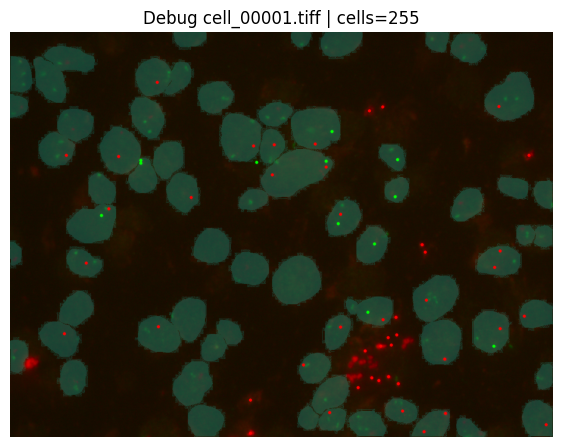

Procesando:   4%|▍         | 1/25 [00:00<00:10,  2.18it/s]

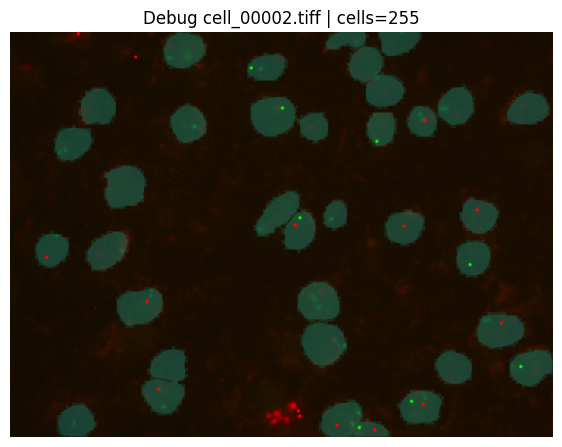

Procesando:   8%|▊         | 2/25 [00:00<00:09,  2.36it/s]

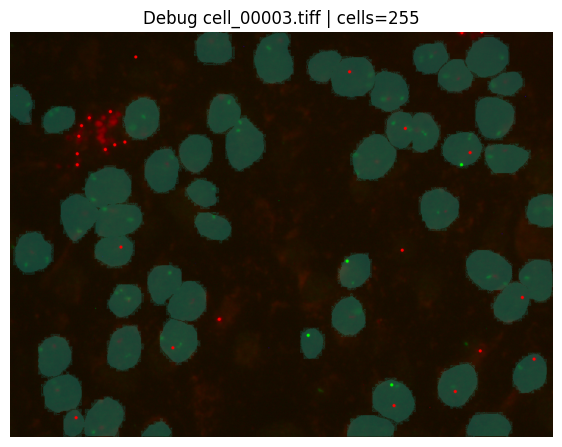

Procesando:  12%|█▏        | 3/25 [00:01<00:09,  2.33it/s]

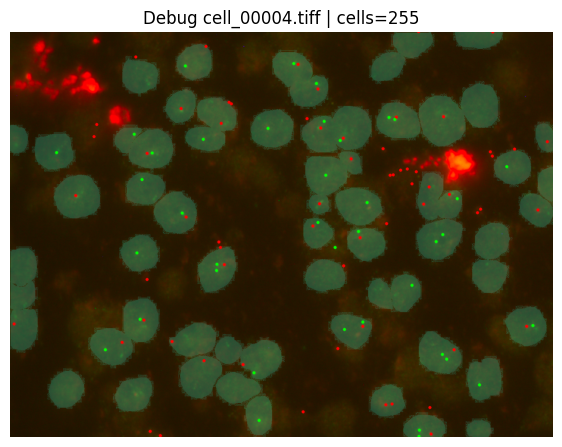

Procesando:  16%|█▌        | 4/25 [00:01<00:09,  2.30it/s]

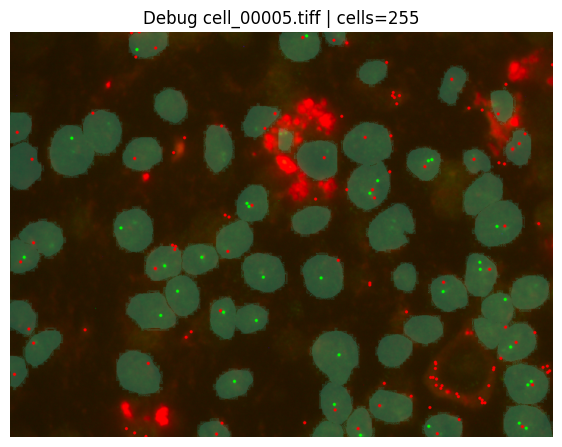

Procesando: 100%|██████████| 25/25 [00:04<00:00,  5.65it/s]

Guardado: resultados_por_celula.csv | filas: 121
Guardado: resumen_global.csv


,class,n_cells,percent
2,a_normal,26,21.487603
0,b_del_1_brazo,48,39.669421
1,c_del_2_brazos,47,38.842975


In [17]:
img_paths = find_images(IMG_DIR)
print("Imágenes encontradas:", len(img_paths))
print("Ejemplo:", os.path.basename(img_paths[0]))

all_df = []
for i, p in enumerate(tqdm(img_paths, desc="Procesando")):
    all_df.append(process_image(p, debug=(i < DEBUG_FIRST_N)))

per_cell_df = pd.concat(all_df, ignore_index=True) if all_df else pd.DataFrame()
per_cell_df.to_csv(OUT_PER_CELL, index=False)
print("Guardado:", OUT_PER_CELL, "| filas:", len(per_cell_df))

if len(per_cell_df) == 0:
    summary_df = pd.DataFrame({"class": [], "n_cells": [], "percent": []})
else:
    summary_df = per_cell_df["class"].value_counts().rename_axis("class").reset_index(name="n_cells")
    summary_df["percent"] = 100.0 * summary_df["n_cells"] / summary_df["n_cells"].sum()
summary_df = summary_df.sort_values("class")

summary_df.to_csv(OUT_SUMMARY, index=False)
print("Guardado:", OUT_SUMMARY)
summary_df


---
## 10) Comparativa Metodológica

### 1. Comparativa Rápida: Matriz Técnica
| Aspecto                          | TFG Vera                     | Nuestro Proyecto                                      | Tipo de Mejora            |
| -------------------------------- | --------------------------------- | ----------------------------------------------------------- | ------------------------- |
| Segmentación de Células          | Li + Canny + Closing (manual)     | Otsu/Adaptive + Distance Transform + Watershed (automático) | Automatización        |
| Detección de Sondas (Rojo)       | Rango RGB directo                 | Rango HSV con 2 componentes                                 | Invariancia a iluminación |
| Detección de Sondas (Verde/Azul) | Extracción RGB simple             | Rango HSV adaptativo + apertura morfológica                 | Robustez             |
| Células Pegadas                  | 16 variantes manualmente testadas | Watershed automático con distance transform                 | Reducción de manual   |
| Filtrado de Ruido                | Área fija: 3-500 píxeles          | Área adaptativa: 3-500 píxeles (contextual)                 | Flexibilidad mejorada     |
---
### 2. Segmentación de Células
#### Vera
```
RGB → Canal Verde → Threshold Li → Canny → Closing (16 variantes)
```

#### Nuestro
```
RGB → Escala gris → Otsu → Distance Transform → Watershed automático
```
**Ventaja:** Automático, no requiere iterar 16 variantes

---
### 3. Detección de Sondas
#### Vera
Problema: sensible a iluminación
#### Nuestro
**Ventaja**: invariancia a iluminación, funciona con fondos distintos

---

### 4. Innovación: Uso de Labels
En nuestro trabajo si existen labels → usar como ground truth

---

## Resumen de Mejoras

- Watershed automático reemplaza 16 variantes manuales  
- HSV es robusto a iluminación variable  
- Escalable a 25 imágenes con mismos parámetros  
- Aprovecha labels cuando disponibles  
- Mayor automatización

- **Limitación común:** Células muy pegadas (5-10% sin resolver)  
- **Limitación común:** Sondas débiles en bajo contraste

---
